# Libraries

In [3]:
import os
import datetime
from math import sqrt
import itertools

# visualisation
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams.update({'figure.figsize': (15, 8), 'figure.dpi': 120})
plt.style.use('fivethirtyeight')

# statsmodel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Meta-data 

- ``global_active_power``: The total active power consumed by the household (kilowatts).
- ``global_reactive_power``: The total reactive power consumed by the household (kilowatts).
- ``voltage``: Average voltage (volts).
- ``global_intensity``: Average current intensity (amps).
- ``sub_metering_1``: Active energy for kitchen (watt-hours of active energy).
- ``sub_metering_2``: Active energy for laundry (watt-hours of active energy).
- ``sub_metering_3``: Active energy for climate control systems (watt-hours of active energy)

In general terms, the <b>active energy</b> is the real power consumed by the household, whereas the reactive energy is the unused power in the lines.

# Data fetching

**Stop and think**   
We should not forget to specify some parameters to ensure the data is loaded correctly:

- Specify the separate between columns as a semicolon (sep=’;’)
- Specify that line 0 has the names for the columns (header=0)
- Specify that we have lots of RAM to avoid a warning that we are loading the data as an array of objects instead of an array of numbers, because of the ‘?’ values for missing data (low_memory=False).
- Specify that it is okay for Pandas to try to infer the date-time format when parsing dates, which is way faster (infer_datetime_format=True)
- Specify that we would like to parse the date and time columns together as a new column called ‘datetime’ (parse_dates={‘datetime’:[0,1]})
- Specify that we would like our new ‘datetime’ column to be the index for the DataFrame (index_col=[‘datetime’]).

In [4]:
# define dataset path
datapath="../data/raw/household_unique/household_power_consumption.txt"

In [5]:
# import / read dateset file
ts_house = pd.read_csv(datapath, sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

# Data scrubbing

In [4]:
# dataset overview
ts_house.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
# renaming columns for better readability
ts_house.columns = ts_house.columns.str.lower()

In [10]:
# dataset summary
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


**Stop and think**     
We need to convert all features instances into float64 before going further through scrubbing, and replace '?' missing values into 'NaNs value as well.

In [7]:
# missing value marking
ts_house.replace('?', np.NaN, inplace=True)

In [8]:
# marking check
ts_house.values[ts_house.values == '?'].sum()

0

In [9]:
# dataset parsing from object into float64
ts_house = ts_house.astype(np.float64)

In [9]:
# parsing check 
ts_house.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    float64
 1   global_reactive_power  float64
 2   voltage                float64
 3   global_intensity       float64
 4   sub_metering_1         float64
 5   sub_metering_2         float64
 6   sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [110]:
# summary statistic
ts_house.describe()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


## Missing values

In [38]:
# missing values check
ts_house.isnull().sum()

global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64

In [47]:
# impute missing values w/ value at the same minute past a day
def fill_missing(df):
	one_day = 60 * 24
	for row in (df.shape[0]):
		if df.index[row].isnull().sum() > 0:
			df[row].value = df[row][].value
  

In [48]:
# instantiate custom imputation function
fill_missing(ts_house.values)

In [10]:
# drop missing values
ts_house = ts_house.dropna()

In [8]:
# missing values drop check
ts_house.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Duplicates

In [9]:
# dataset duplicates ratio check
ts_house.duplicated().value_counts()

False    1906698
True      142582
dtype: int64

**Summary**     
- Converted object features into float64
- Replaced '?' into NaNs
- 25979 missing values dropped
- 142582 duplicates not dropped

**Done**

---------------------------------------------------------

# Exploratory data analysis

Most commonly, a time series is a sequence taken at successive equally spaced points in time.     
Time series data is composed of four elements as shown in the picture above.

![image](https://miro.medium.com/max/700/1*FW0EAKrdzHwh58lmumonbA.png)

## Univariate analysis

In [11]:
# resample time series in hours for analysis
ts_house = ts_house.resample('h').sum()

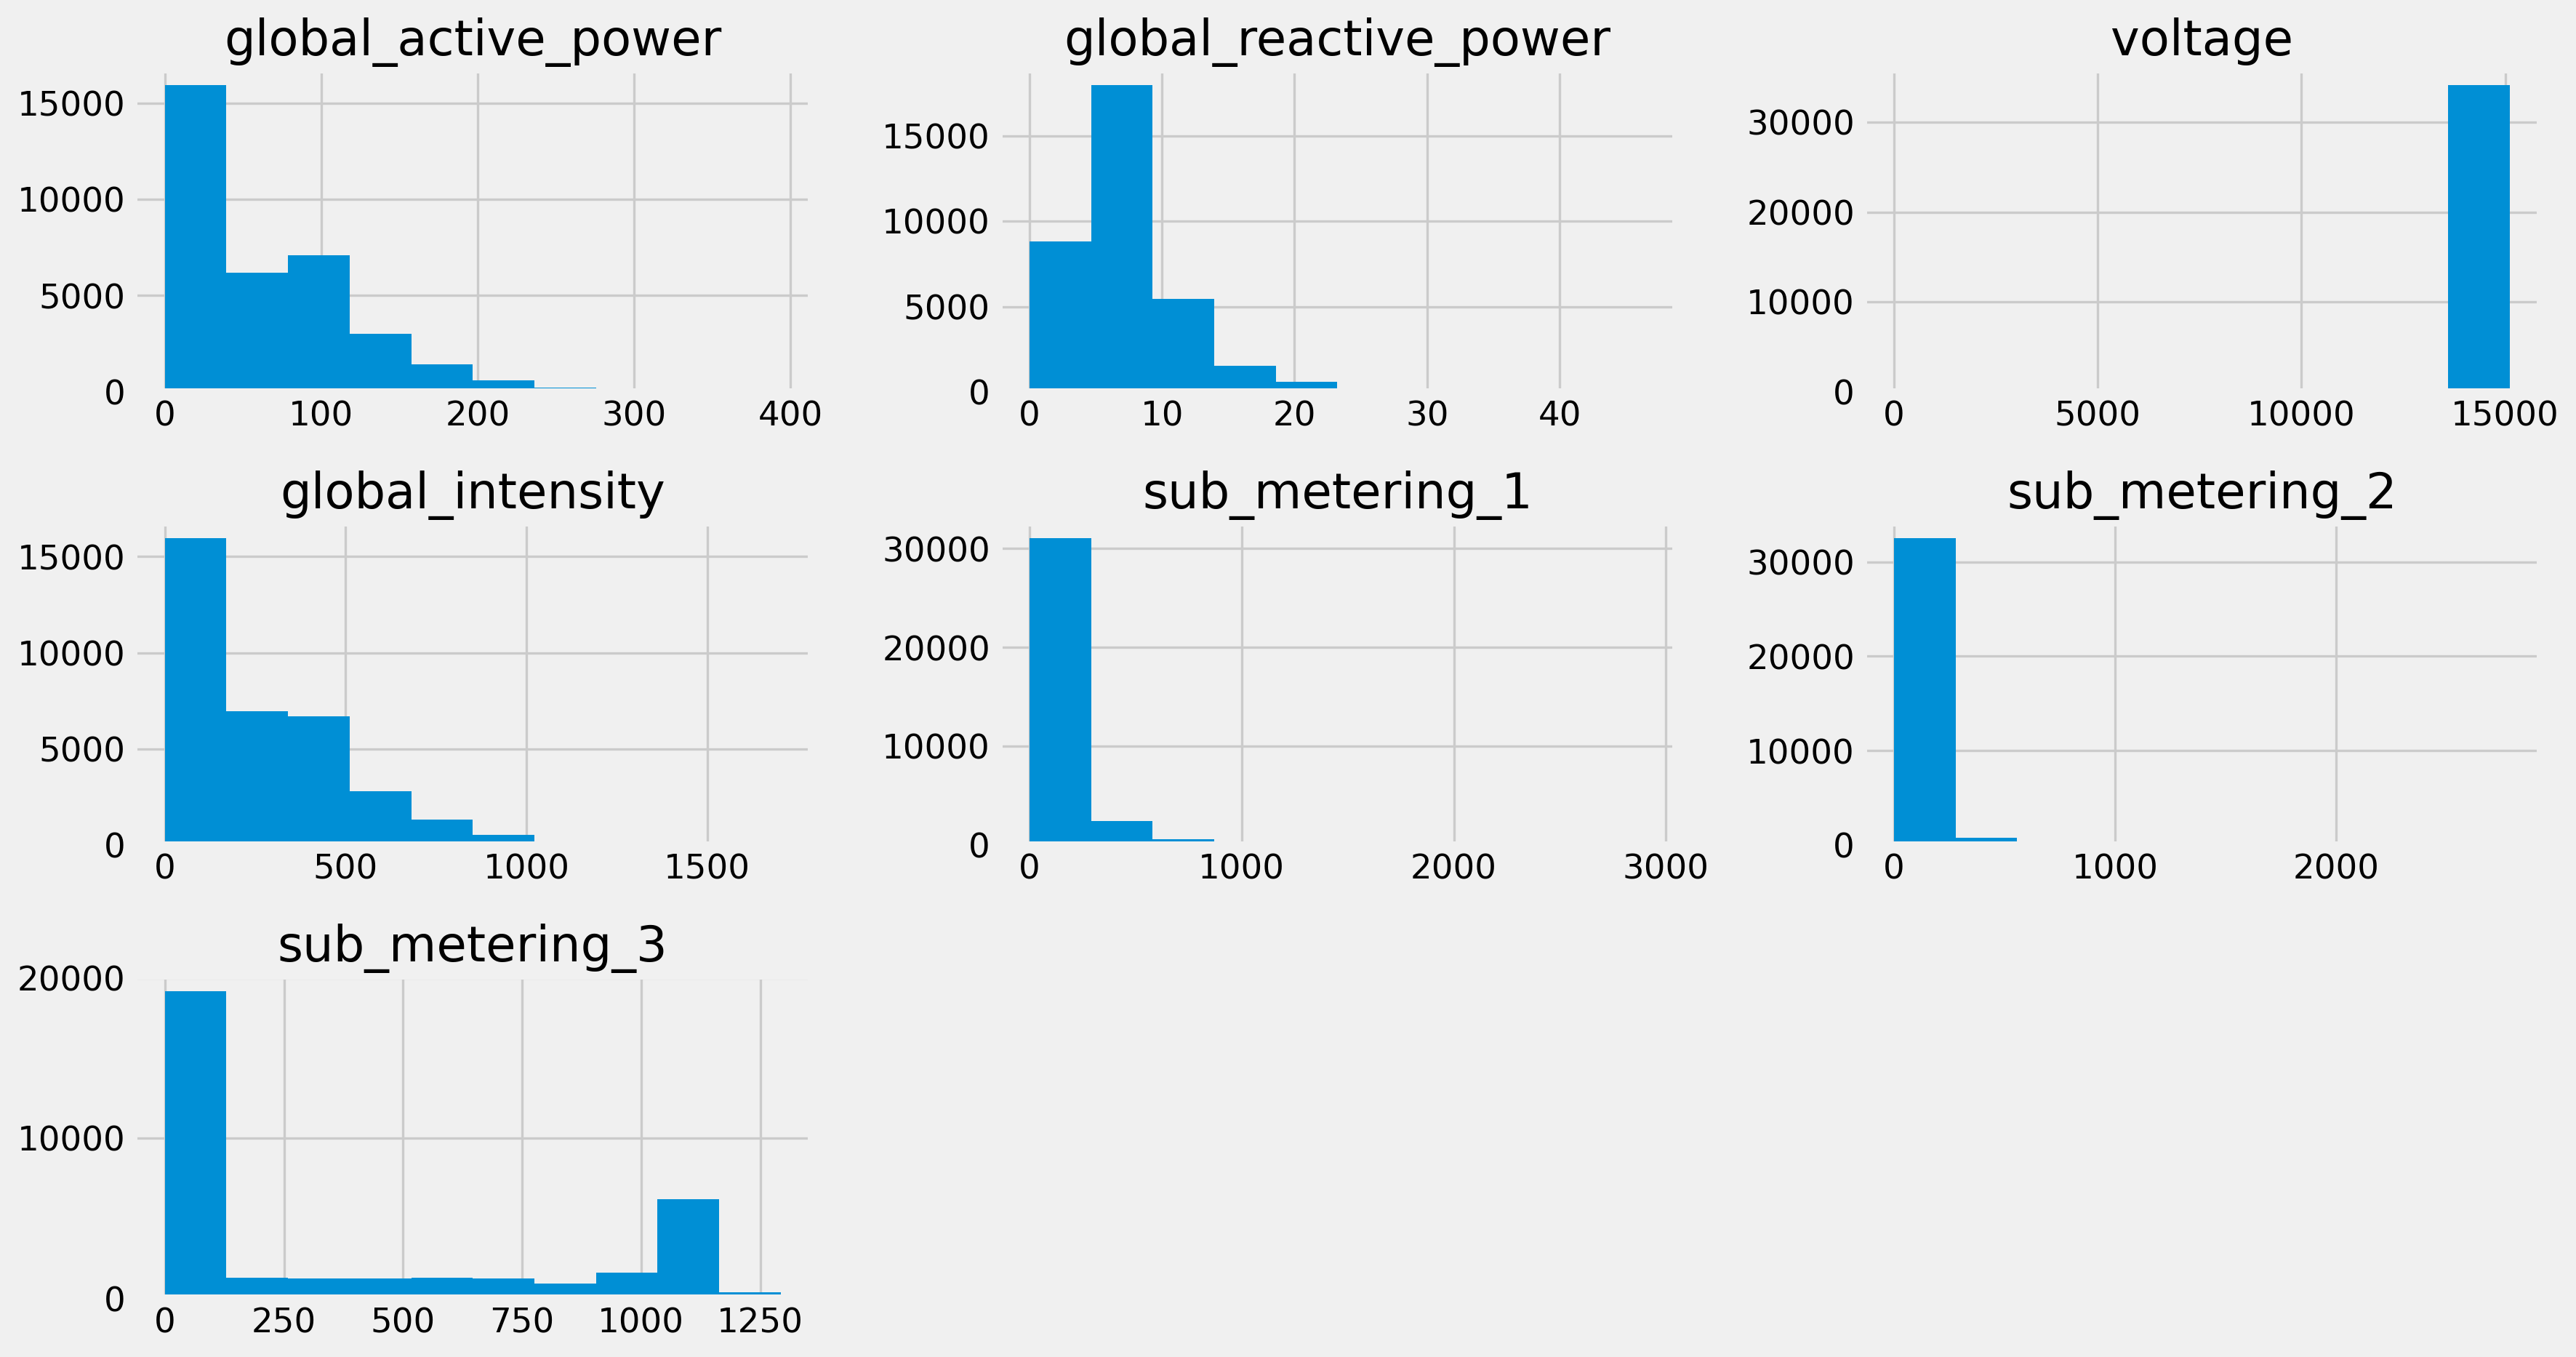

In [85]:
ts_house.hist()
plt.tight_layout()
plt.show()

### Line plot

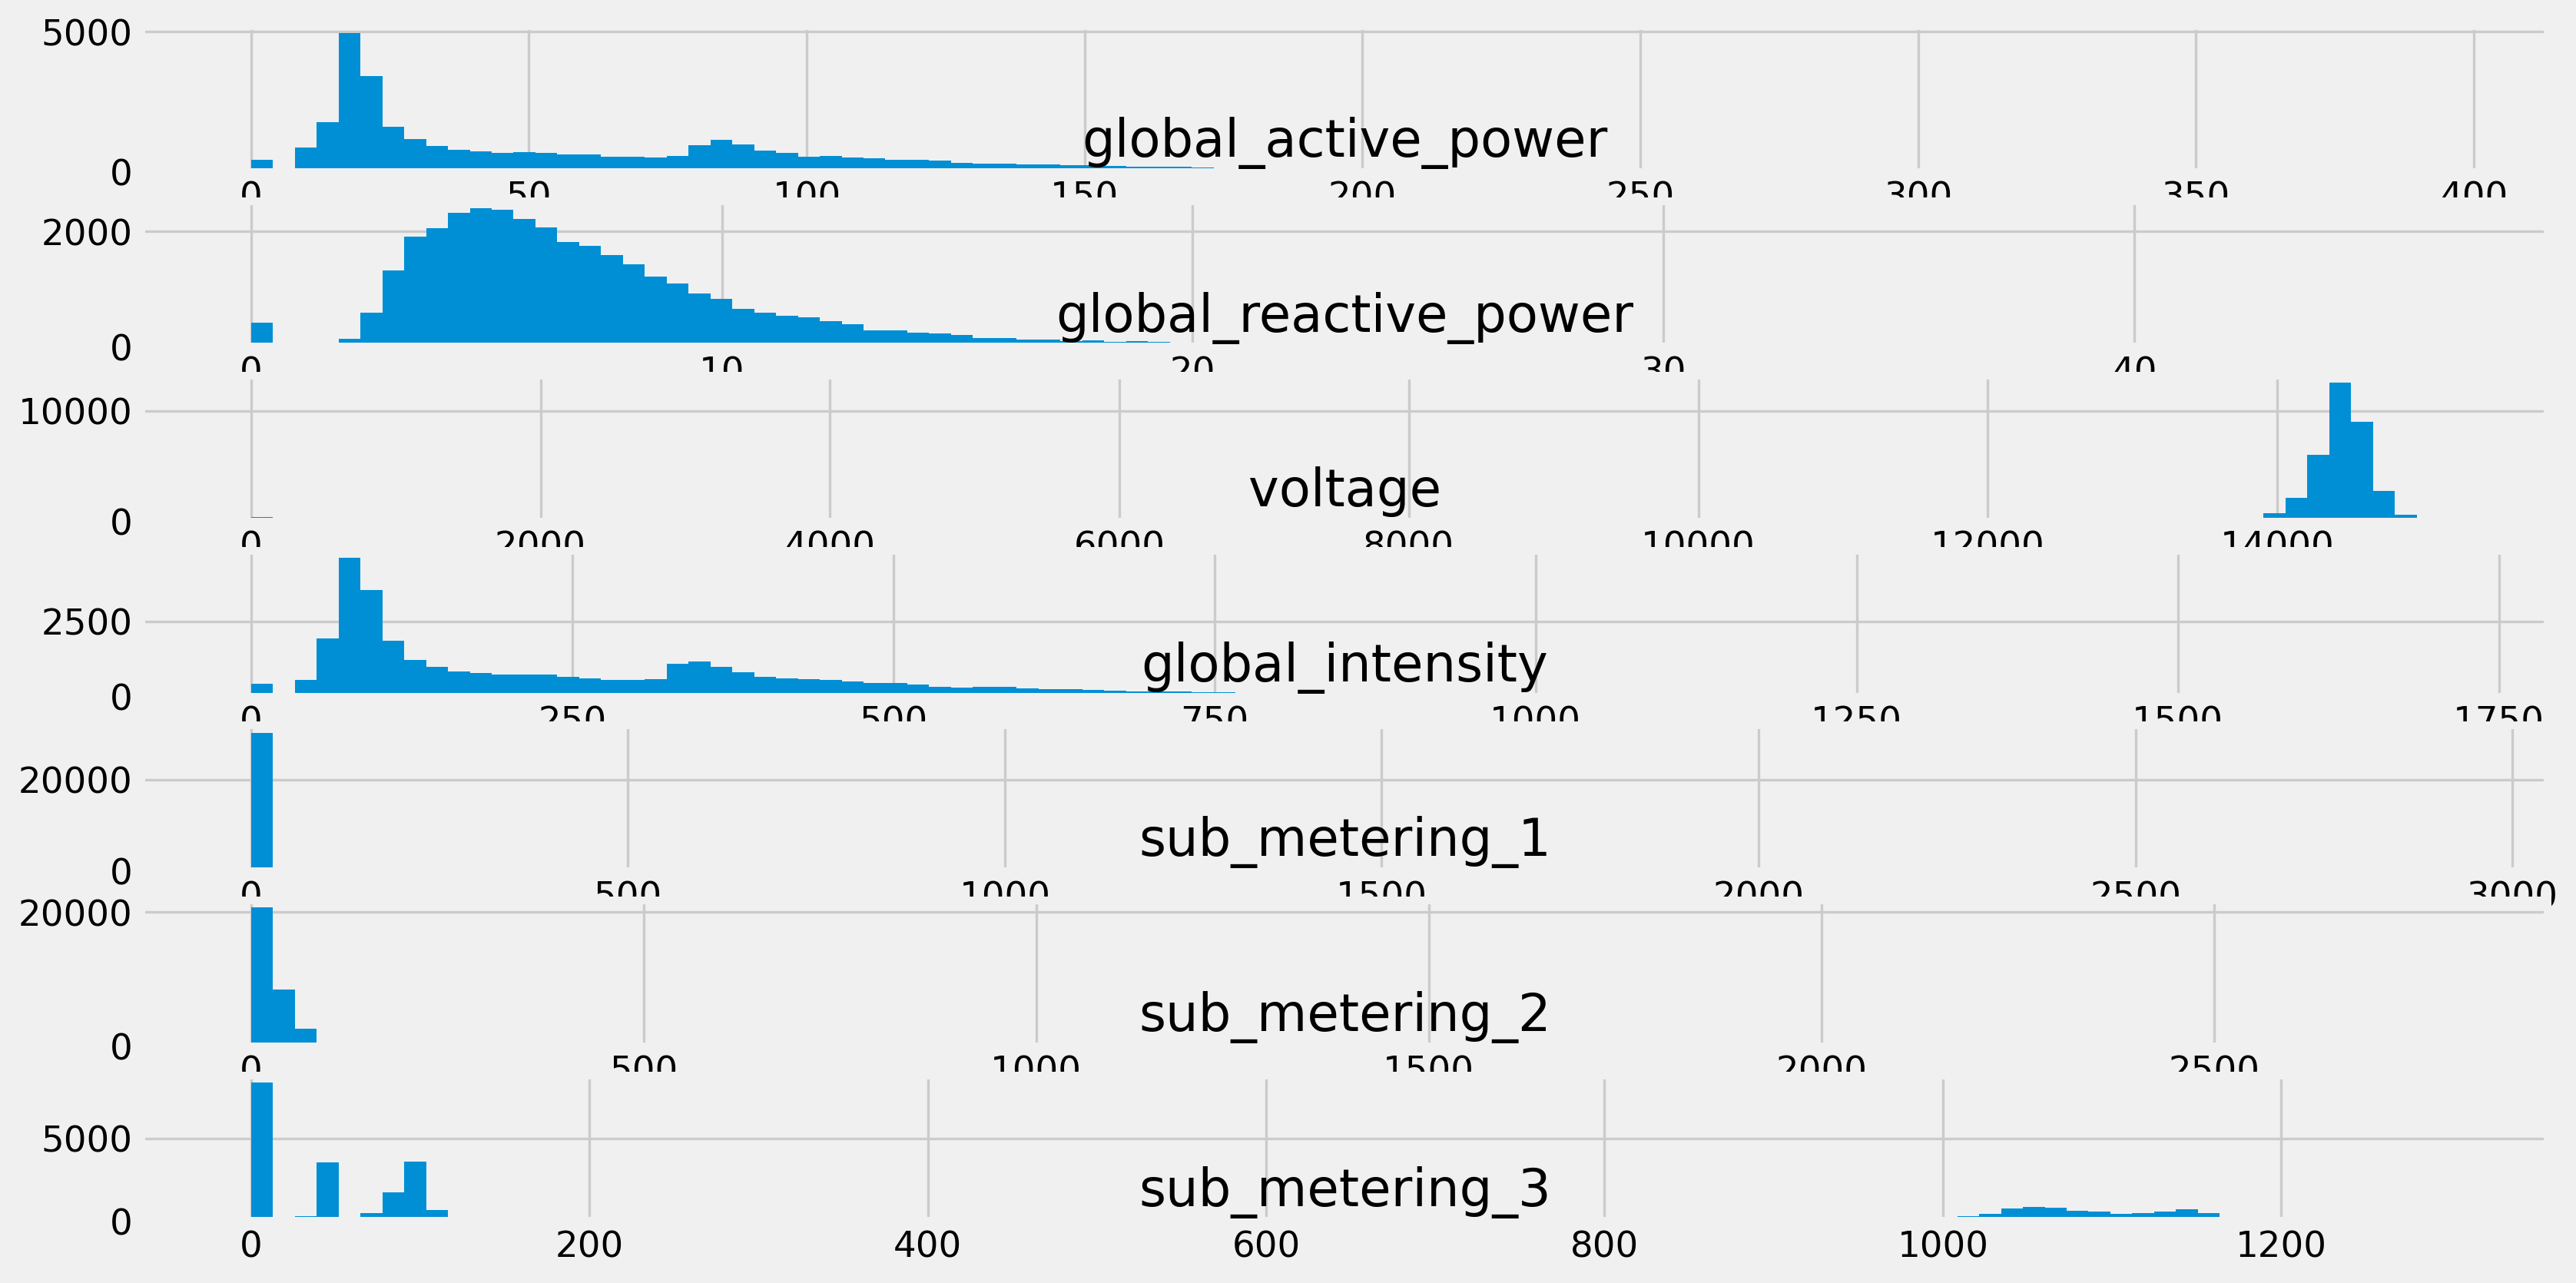

In [94]:
# features line plot
for i in range(len(ts_house.columns)):
	plt.subplot(len(ts_house.columns), 1, i+1)
	name = ts_house.columns[i]
	ts_house[name].hist(bins=100)
	plt.title(name, y=0)
plt.show()

### Distribution plot 

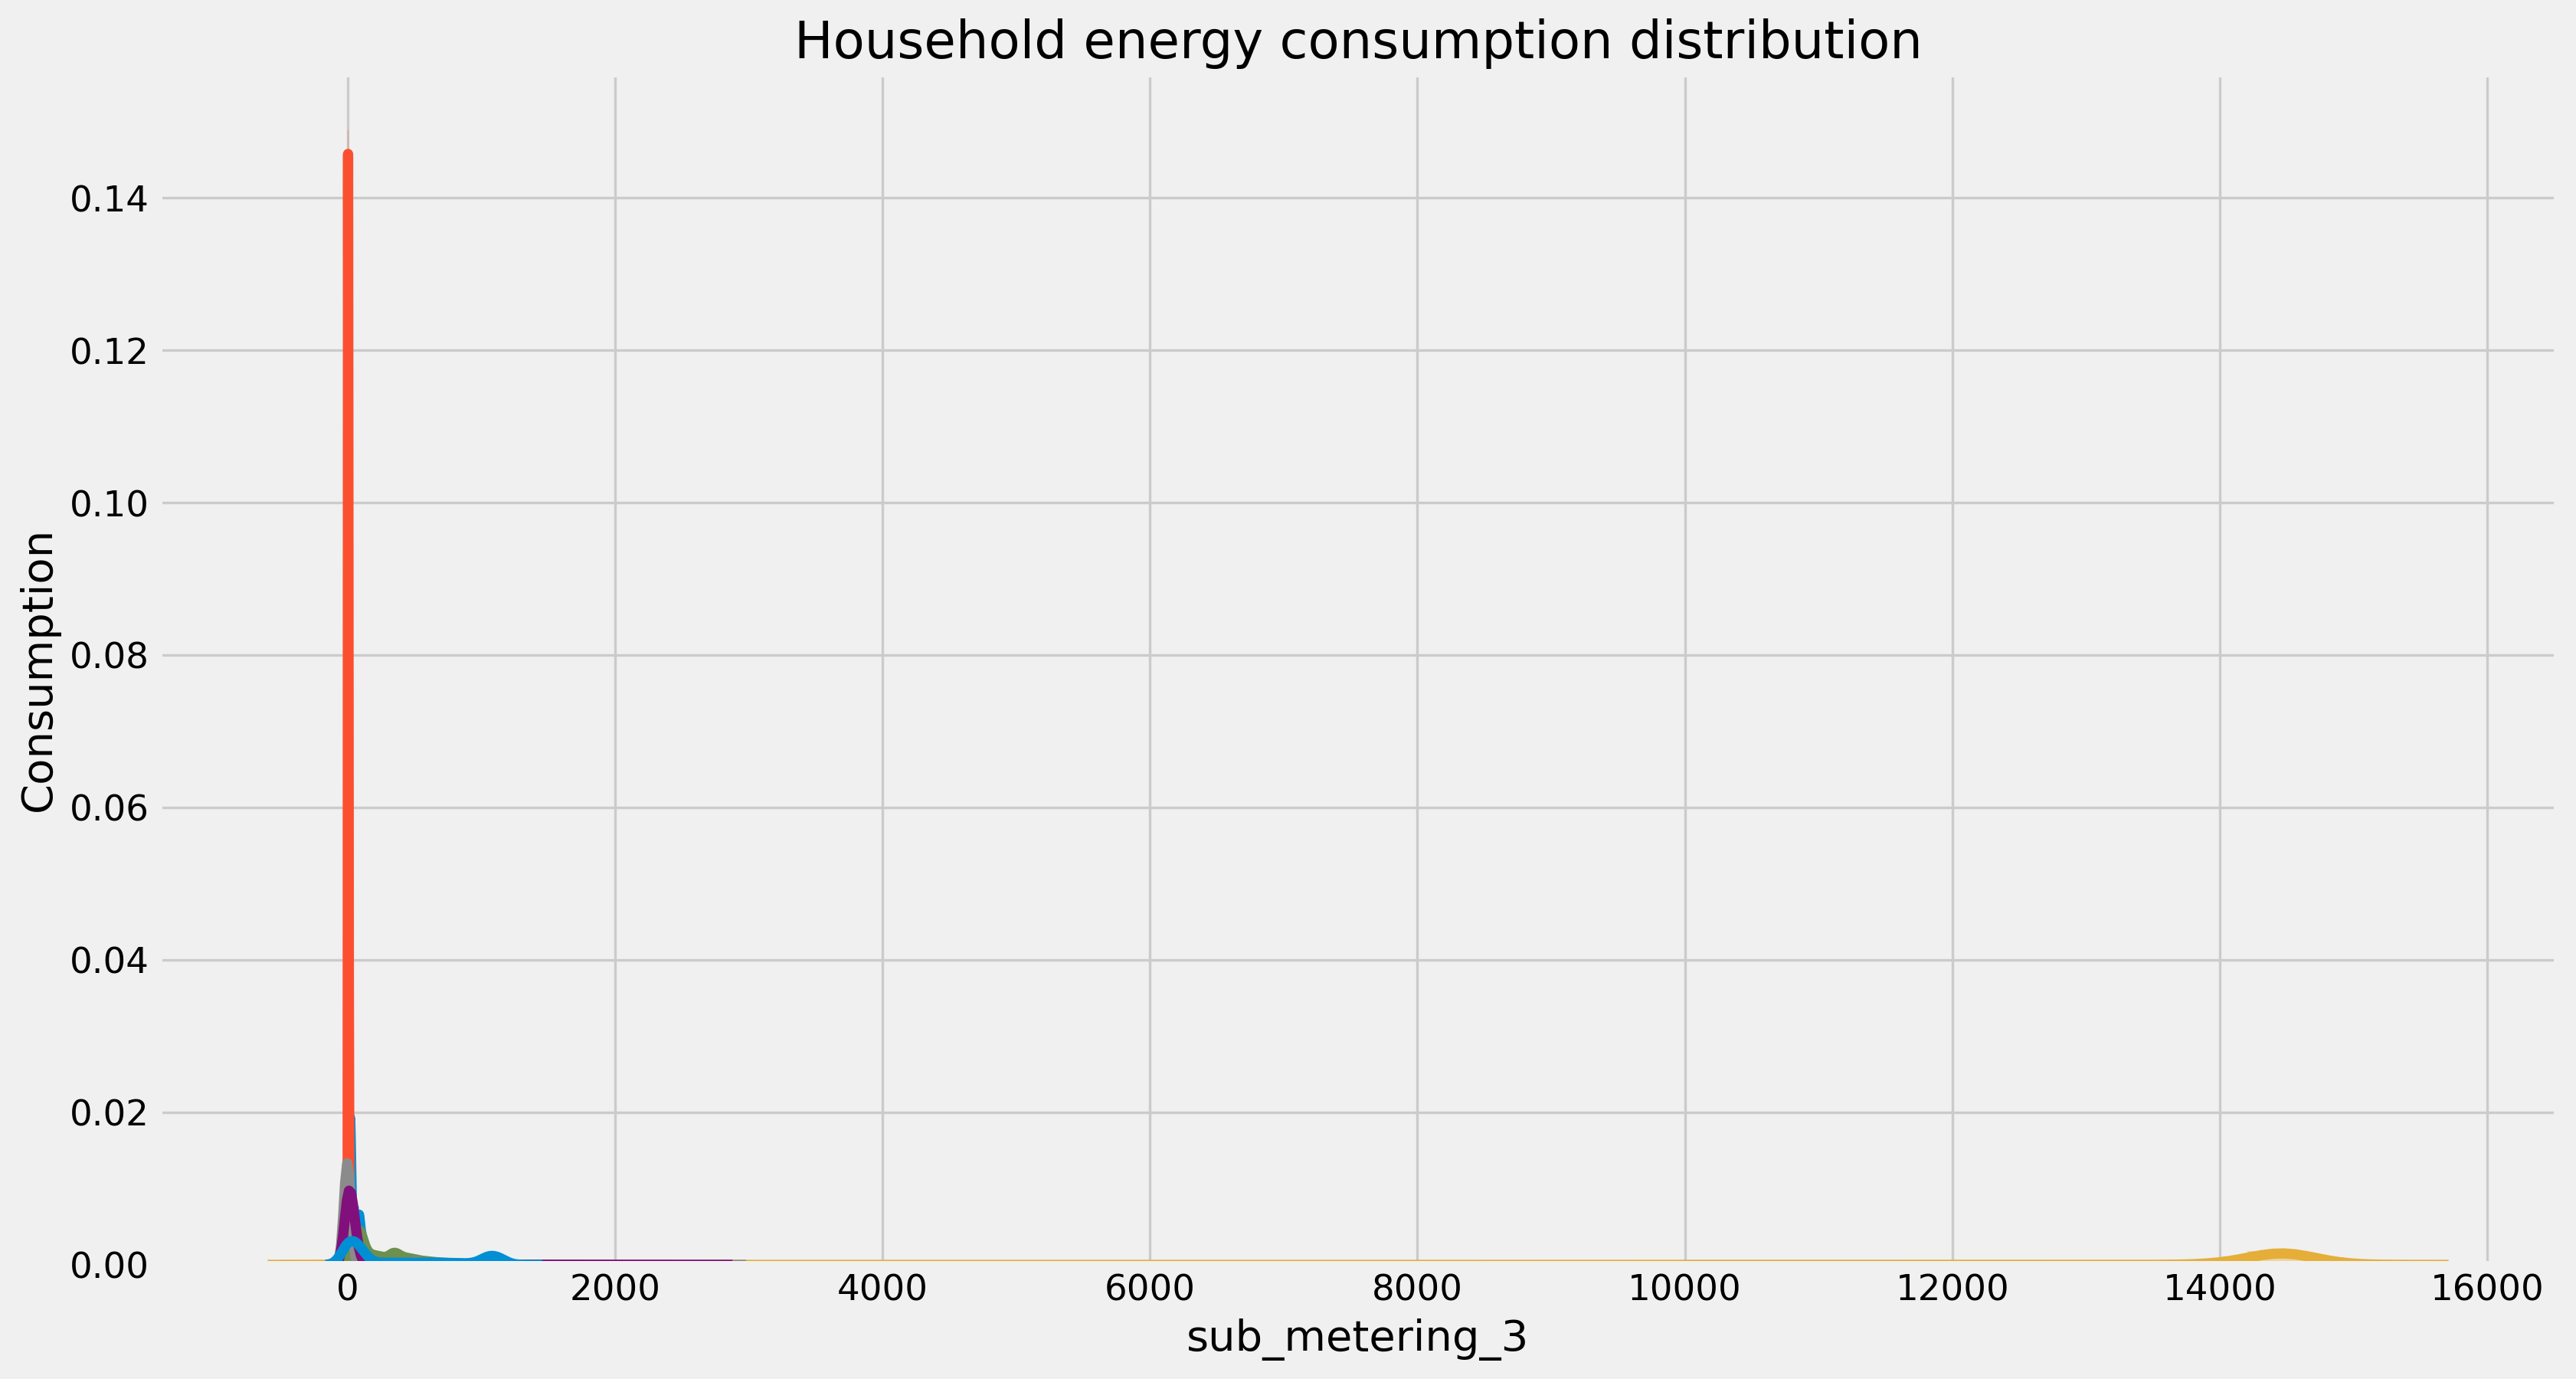

In [99]:
# distribution plot 
for col in ts_house.columns:
    plt.xlabel("Date")
    plt.ylabel("Consumption")
    plt.title("Household energy consumption distribution")
    sns.distplot(ts_house[col])


## Components decomposition

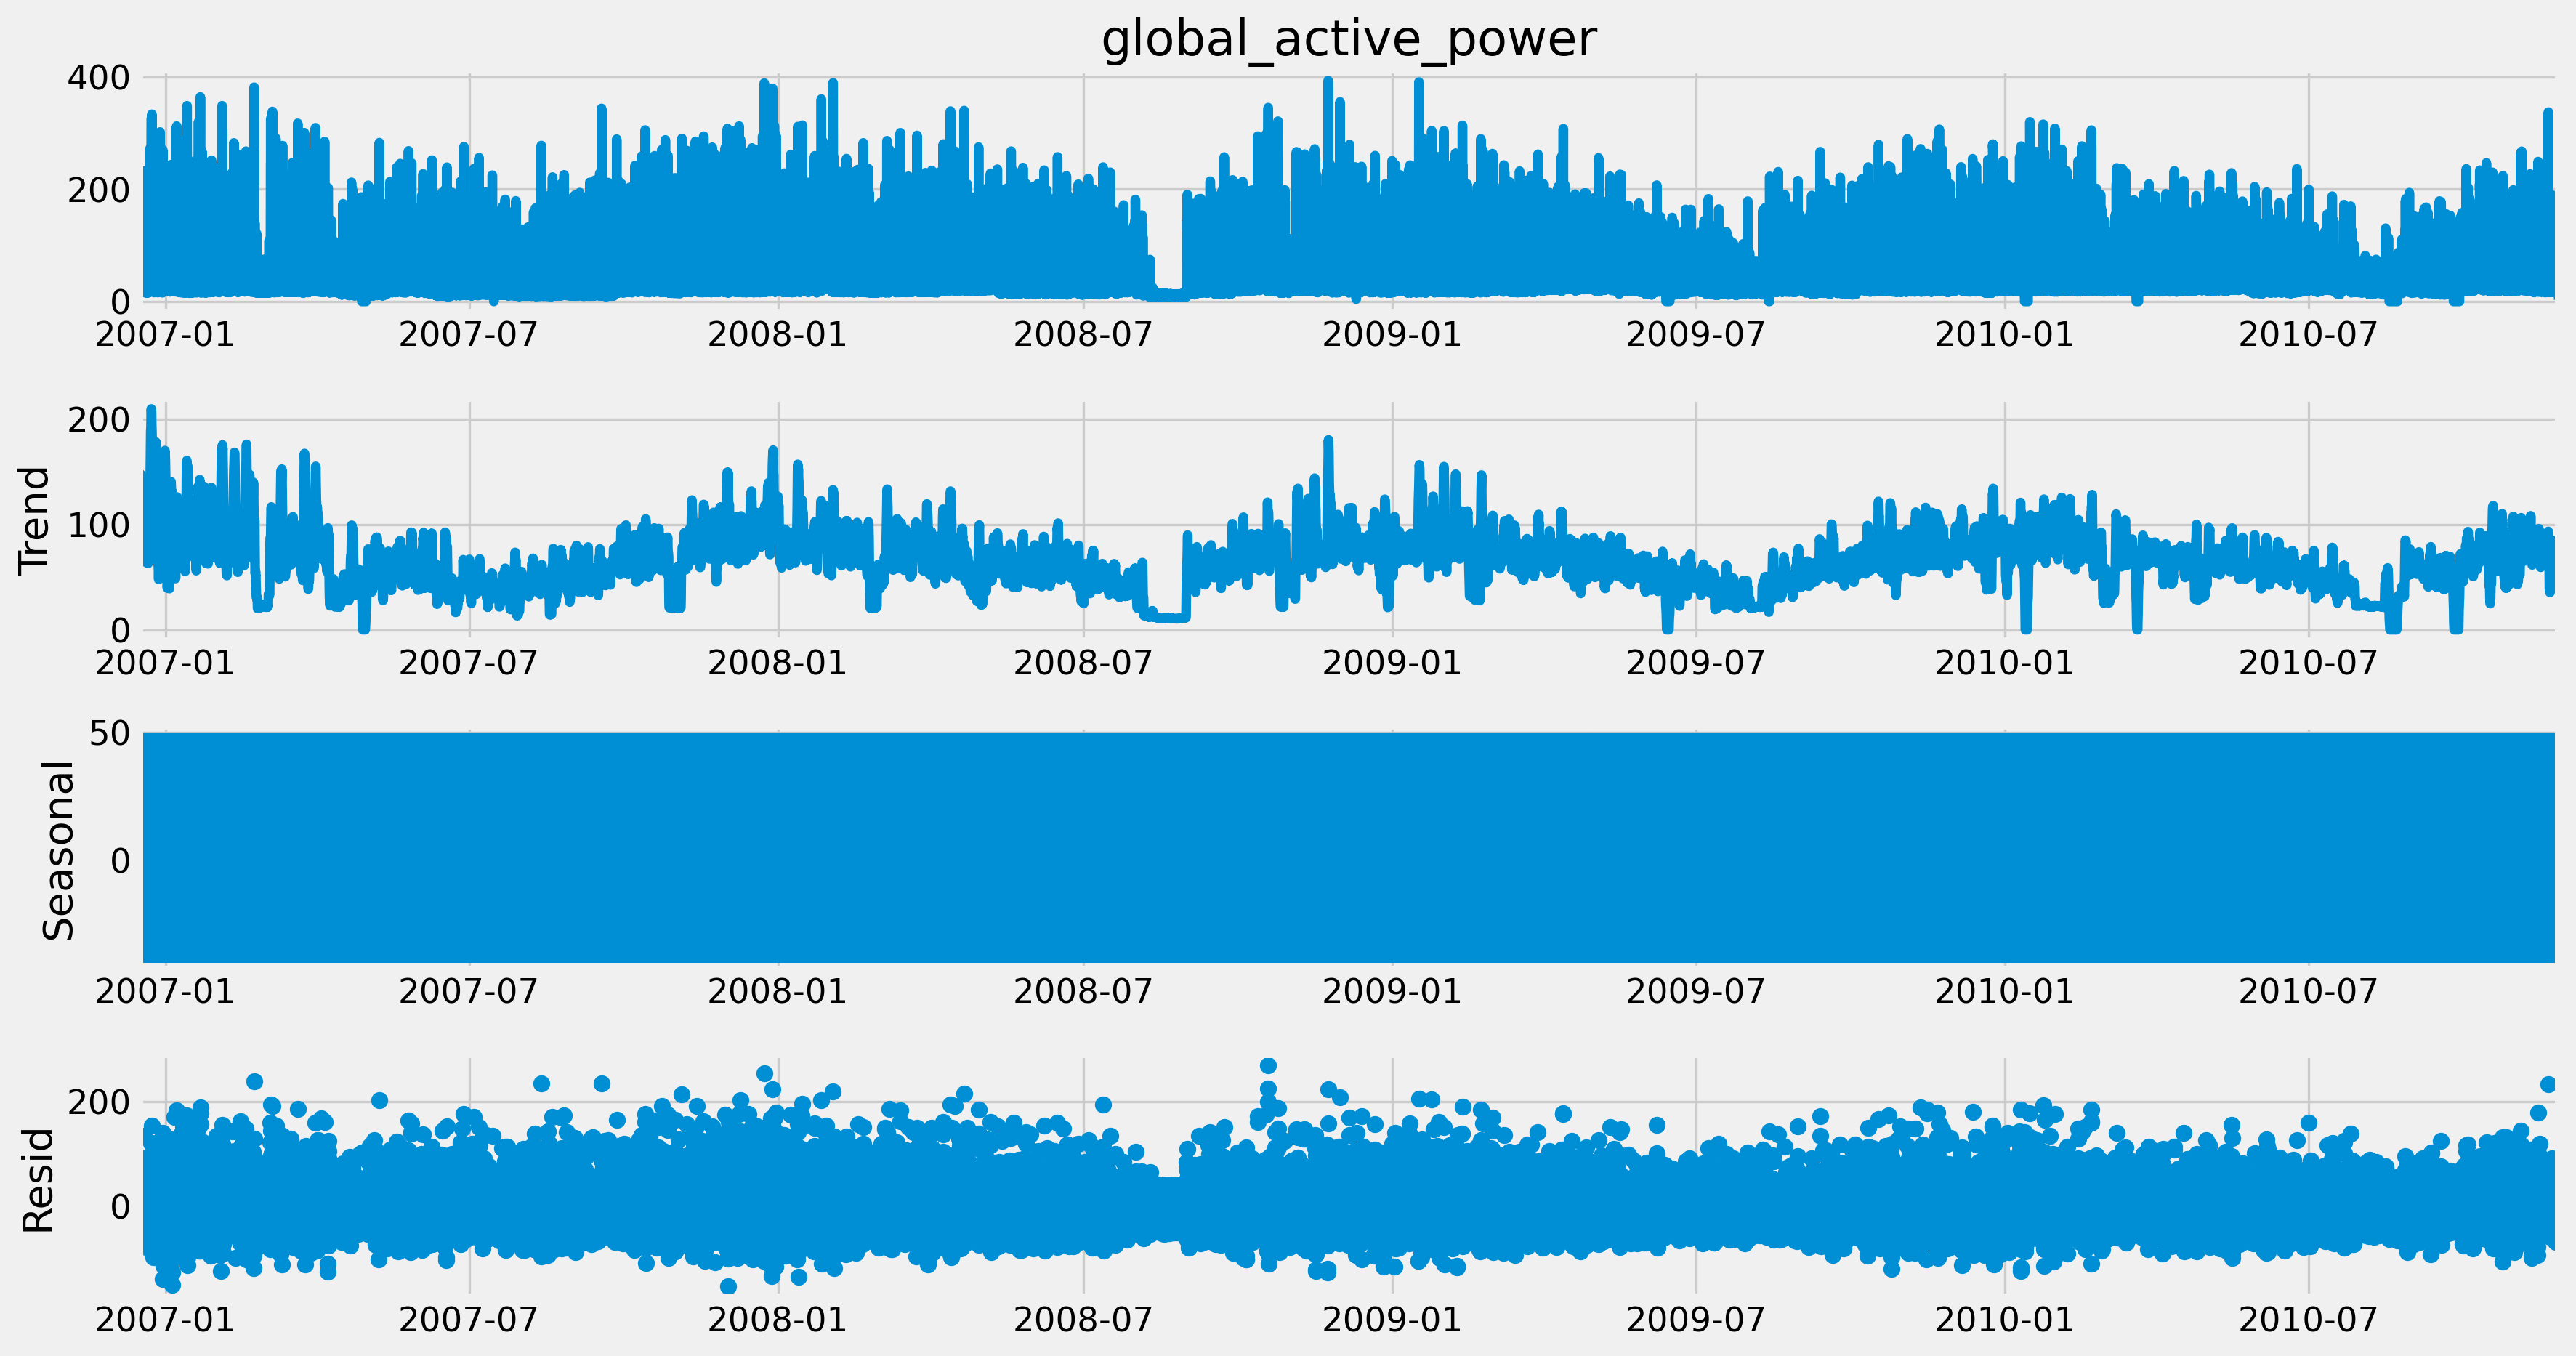

In [100]:
# decompose times series to distinct trend, seasonality and noise
decomposition = seasonal_decompose(ts_house['global_active_power'], model='additive')
fig = decomposition.plot()
fig.show()

## Stationarity 

### Visualization

In [79]:
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

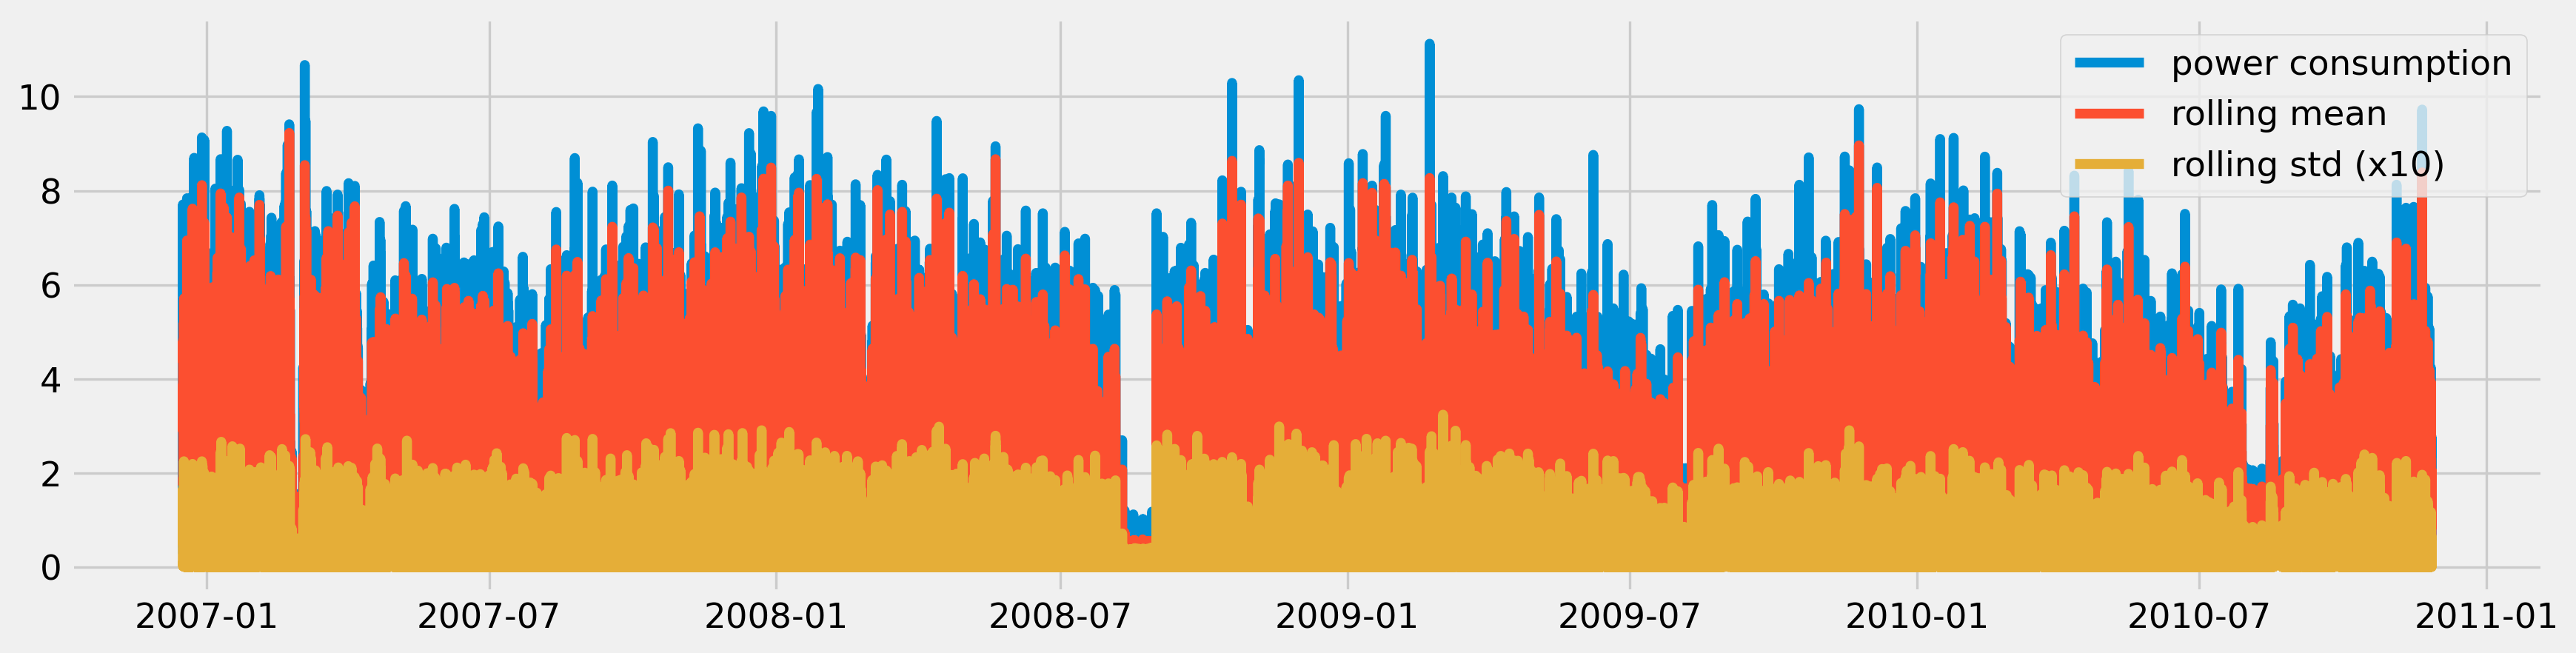

In [81]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(ts_house['global_active_power'], 'power consumption')

### Augmented Dickey-Fuller (ADF) Test

In [101]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [106]:
for col in ts_house.columns[:-3]:
    ADF_test(ts_house[col], f'{col} power time series')

 > Is the global_active_power power time series stationary ?
Test statistic = -14.314
P-value = 0.000
Critical values :
	1%: -3.4305393559398922 - The data is  stationary with 99% confidence
	5%: -2.8616236906108443 - The data is  stationary with 95% confidence
	10%: -2.566814545887977 - The data is  stationary with 90% confidence
 > Is the global_reactive_power power time series stationary ?
Test statistic = -14.846
P-value = 0.000
Critical values :
	1%: -3.4305393559398922 - The data is  stationary with 99% confidence
	5%: -2.8616236906108443 - The data is  stationary with 95% confidence
	10%: -2.566814545887977 - The data is  stationary with 90% confidence
 > Is the voltage power time series stationary ?
Test statistic = -17.134
P-value = 0.000
Critical values :
	1%: -3.4305393614231567 - The data is  stationary with 99% confidence
	5%: -2.8616236930342334 - The data is  stationary with 95% confidence
	10%: -2.5668145471778843 - The data is  stationary with 90% confidence
 > Is the 

In [108]:
for col in ts_house.columns[4:]:
    ADF_test(ts_house[col], f'{col} power time series')

 > Is the sub_metering_1 power time series stationary ?
Test statistic = -22.984
P-value = 0.000
Critical values :
	1%: -3.4305393559398922 - The data is  stationary with 99% confidence
	5%: -2.8616236906108443 - The data is  stationary with 95% confidence
	10%: -2.566814545887977 - The data is  stationary with 90% confidence
 > Is the sub_metering_2 power time series stationary ?
Test statistic = -31.995
P-value = 0.000
Critical values :
	1%: -3.4305392682508304 - The data is  stationary with 99% confidence
	5%: -2.861623651855698 - The data is  stationary with 95% confidence
	10%: -2.5668145252596126 - The data is  stationary with 90% confidence
 > Is the sub_metering_3 power time series stationary ?
Test statistic = -14.189
P-value = 0.000
Critical values :
	1%: -3.4305393504569457 - The data is  stationary with 99% confidence
	5%: -2.8616236881875956 - The data is  stationary with 95% confidence
	10%: -2.5668145445981443 - The data is  stationary with 90% confidence


**Summary**
- All time series' features are statioanary w/ a p_value < 0.05 and a mean stationary confidence score of 95%.

## Dataset export

In [12]:
ts_house.shape

(34589, 7)

In [15]:
# save updated dataset
ts_house.to_csv('../data/interim/household_unique/household_power_consumption_interim.csv', index_label=False)

-------------------------------------------------------